## Introduction:

This is a guide for those who are not familiar with most of the concepts presented( and still wants to understand how people have approached this). With a score of around 6.85( not great, not terrible) it should be plenty enough to gain a lot of knowledge like I did. As a beginner into all this, I spend time understanding and studying the problem and would love to give those who do not want to spend as much time as I did a head start. That also means like every other work, this is imperfect and there might be innacuracies. I started this project with little knowledge on medical imaging data, image processing as well as how to work with uncertainty. Here are a few ways people went around these problems. Do note that there is a little to no EDA done in this particular notebook( however, there are plenty available exclusively on EDA which has been done really well). 

The main concepts that is going to be looked at include :
1. A basic overview of the data and the problem at hand.
2. A explanation of how medical imaging works and their components.
3. A simple explanation of of how uncertainty has been approached and an explanation and understanding of pinball loss.
4. A basic understanding of the metric.
5. The approach I took and what can be done further with more time, effort and computation.
6. An explanation of how the scoring, submission etc works.


* Do note that there are a few attached files other than the ones provided. These are mostly due to the fact that is an offline competition. Running this notebook online and changing a few lines of code will make this work with no issues.

### Installing libraries:

In [1]:
# Some basic libararies:
import os
import sys
import subprocess
# We can use !pip install instead of what we have done below:
def install(package):
    subprocess.check_call([sys.executable, "-m", "pip","install",package])
install("../input/fastremap/fastremap-1.10.2-cp37-cp37m-manylinux1_x86_64.whl")
install("../input/fillvoids/fill_voids-2.0.0-cp37-cp37m-manylinux1_x86_64.whl")
install("../input/finalmask")
install("pydicom")

In [2]:
#importing libraries for the analysis

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm.notebook import tqdm
import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras.backend as kb

# Pydicom is the library used to work with  the medical image data(further explanation below):
import pydicom
from pydicom.data import get_testdata_files

import os
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder 
from sklearn import preprocessing 
from tensorflow import keras
import keras.backend as kb
from sklearn.model_selection import train_test_split

sns.set(style="whitegrid")
sns.set_context("paper")

# lungmask is what we use to get a segmented version of the image data( further explanation and credits below):
from lungmask import mask
import SimpleITK as sitk
import math

In [3]:
# This block of code makes all the random points reproducible( by setting a seed):
import random
def seed_everything(seed=2020):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
seed_everything(42)

## A basic overview of the tabular data, variables involved as well as an modifying the data for the final analysis:
There are 3 csv files in the provided dataset, namely the train.csv, test.csv and sample_submission.csv. First let us take a look at the train csv.

In [4]:
ROOT = "../input/osic-pulmonary-fibrosis-progression"
train=pd.read_csv(f"{ROOT}/train.csv")
train.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


There are essentially multiple data points for each patient. These data points indicate to the condition of the patient at any given week. So if the weeks column indicates 7, it means the data point is taken 7 weeks after the CT scan is taken and if weeks indicate -4 it means that the reading was taken 4 weeks before the CT scan. 


Now what are we reading exactly? The main varialbe in concern here is FVC( forced vital capacity, i.e. the volume of air exhaled.) Essentially, people with pulmonary fibrosis sees increasing levels of fibrotic tissue( or hardened tissue which essentially renders that tissue unsuitable for lung function) in their lungs which in turn decreases their FVC ( lung capacity of sort). So the main task at hand is to predict this decline in FVC. The reason this challenge is put up is due to the fact that the way pulmonary fibrosis progresses is very difficult to predict and doctors find it really hard to accurately give proper timelines for the progression of this disease.

That is where we come in. Our task at hand is to predict what the patients FVC value will be at a given week. To get a deeper better insight into what the disease is about with more indepth  I would highly recommend https://www.kaggle.com/c/osic-pulmonary-fibrosis-progression/discussion/165727 this discussion by Dr. Konya which is a really well put discussion thread about the disease itself and a few ways to go about working with the image data. The rest of the columns are self explanatory such as sex, age and smoking status. One final column is percent which essentially gives an estimatation of the percent of FVC  that a given person has in comparison to a healthy individual. For EDA and the relationships between all these variables I would recommend one of many notebooks available and you may find some very interesting information such as https://www.kaggle.com/piantic/osic-pulmonary-fibrosis-progression-basic-eda .

And finally about the data, there are a total of 176 patients in the training set with a total of 1549 datapoints. The "test" csv is just a representation of how the data will look like but in actuality the test data is not visible and will be run only when we submit the file( mostly to keep it from leaking). A slightly more detailed explanation will be given about submission and the various points to note towards the end.


Now we will take a look at the test csv and the submission csv as well.

In [5]:
sample_submission=pd.read_csv(f"{ROOT}/sample_submission.csv")


test=pd.read_csv(f"{ROOT}/test.csv")
# Showing the first 5 rows of the test set:
test.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00419637202311204720264,6,3020,70.186855,73,Male,Ex-smoker
1,ID00421637202311550012437,15,2739,82.045291,68,Male,Ex-smoker
2,ID00422637202311677017371,6,1930,76.672493,73,Male,Ex-smoker
3,ID00423637202312137826377,17,3294,79.258903,72,Male,Ex-smoker
4,ID00426637202313170790466,0,2925,71.824968,73,Male,Never smoked


A few things to note is that the test csv looks very similar to the train set. A few crucial differences exist too. For one, the target variable "FVC" is missing, and next, slightly less obviously is that each patient has only one datapoint given unlike the train set in which each patient has approximately around 8-10 datapoints each. Now we will take a look at the sample_submission csv and get a better understanding of what is expected of us.

In [6]:
sample_submission

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,2000,100
1,ID00421637202311550012437_-12,2000,100
2,ID00422637202311677017371_-12,2000,100
3,ID00423637202312137826377_-12,2000,100
4,ID00426637202313170790466_-12,2000,100
...,...,...,...
725,ID00419637202311204720264_133,2000,100
726,ID00421637202311550012437_133,2000,100
727,ID00422637202311677017371_133,2000,100
728,ID00423637202312137826377_133,2000,100


This dataset looks completely different from the train and test csvs as well as a few interesting characteristics. The first column is the patient_week column which indicates the patient id and the week for which we are making a prediction. Another point to note is that we have to make a prediction for the FVC for every week from -12 to 133. This is done to reduce data leakage. ( essentially the host has a few weeks of data and they compare those weeks to our predictions. We do however make predictions for each and every week from -12 to 133 so that they do not have to release what weeks FVC values we need to predict for. With this in mind we will be modifying our train as well as test set to optimize it. Another important column is the confidence column which will have a seperate section later in the notebook.

Below, we have converted our data into a rather convinient format.

In [7]:
# all this code may seem like a lot, but in the next step  I will be explaining exactly what the end result is and you will be able to replicate using some basic numpy and pandas manipulation
train['Patient_Week']=train['Patient']+'_'+train['Weeks'].astype(str)
lists=train['Patient_Week'][train.duplicated(['Patient_Week'], keep=False)].unique().tolist()
for patient_week in lists:
  new_row=train.loc[train['Patient_Week']==patient_week].groupby(['Patient','Weeks','Age','Sex','SmokingStatus','Patient_Week']).mean().copy()
  train=train[train['Patient_Week']!=patient_week]
  train=train.append(new_row.reset_index())
add=train.copy()
add.rename(columns={'Weeks':'base_weeks','FVC':'base_fvc'},inplace=True)
final=train.merge(add,on='Patient')
final.drop(['Patient_Week_x','Age_y','Sex_y','SmokingStatus_y','Percent_y'],axis=1,inplace=True)
final.rename(columns={'Weeks':'base_week','FVC':'base_fvc','base_fvc':'FVC','Percent_x':'base_percent','Patient_Week_y':'Patient_Week','Age_x':'Age','Sex_x':'sex','SmokingStatus_x':'smokingstatus','base_weeks':'predict_week'},inplace=True)
final['weeks_passed']=final['predict_week']-final['base_week']
cols=['Patient','Patient_Week', 'base_week', 'base_fvc', 'base_percent', 'Age', 'sex','smokingstatus','predict_week','weeks_passed', 'FVC']
final=final[cols]
final=final.loc[final['weeks_passed']!=0]
final.reset_index(drop=True,inplace=True)
final.head()
# here, final is our modified training data.

,Patient,Patient_Week,base_week,base_fvc,base_percent,Age,sex,smokingstatus,predict_week,weeks_passed,FVC
0,ID00007637202177411956430,ID00007637202177411956430_5,-4,2315.0,58.253649,79,Male,Ex-smoker,5,9,2214.0
1,ID00007637202177411956430,ID00007637202177411956430_7,-4,2315.0,58.253649,79,Male,Ex-smoker,7,11,2061.0
2,ID00007637202177411956430,ID00007637202177411956430_9,-4,2315.0,58.253649,79,Male,Ex-smoker,9,13,2144.0
3,ID00007637202177411956430,ID00007637202177411956430_11,-4,2315.0,58.253649,79,Male,Ex-smoker,11,15,2069.0
4,ID00007637202177411956430,ID00007637202177411956430_17,-4,2315.0,58.253649,79,Male,Ex-smoker,17,21,2101.0


This is a major modification to our data. So essentially, we have converted each and every week as something called base week. Let us say, for the first reading was taking at week -4. Now we take this week and predict how the patient does at say week 5( or 9 weeks later). This difference is what we will be essentially predicting. This works well as our test set only has one reading per patient and for each of these readings we have to predict for the weeks from -12 to 133.  So in the test set, each patient by design has a base week and its readings along with its various readings. 

Do take note that base week does not mean the first week that a patient took reading. It just is a placeholder in relation to another week. So essentially, we will be predicting FVC values for the weeks -12 to 133 given the value of FVC for the " base week" which in the case of the first patient in our test set is 6. 

The advantage of taking this approach is that the number of datapoints in our train set increases exponentially as every datapoint for a patient acts a base datapoint as well and mimics the test set with the additional dependant variables such as base_fvc and base_week. Essentially, we will be predicting the difference between two datapoints.

Next, we format the test set in a similar way.

In [8]:
# Similar to our train set, formatting the test set is rather basic and with an understanding of what I am trying to implement you should be able to replicate with a basic understanding of pandas and numpy
test.rename(columns={'Weeks': 'base_Week', 'FVC': 'base_FVC', 'Percent': 'base_Percent', 'Age': 'base_Age'},inplace=True)
Week=sample_submission['Patient_Week'].apply(lambda x : x.split('_')[1]).unique()
Week=np.tile(Week, len(test['Patient']))
test=test.loc[test.index.repeat(146)].reset_index(drop=True)
test['predict_week']=Week

test['Patient_Week']=test['Patient']+'_'+test['predict_week']


test['weeks_passed']=test['predict_week'].astype(int)-test['base_Week'].astype(int)

test.rename(columns={'base_Week':'base_week','base_FVC':'base_fvc','base_Percent':'base_percent','base_Age':'Age','Sex':'sex','SmokingStatus':'smokingstatus'},inplace=True)

cols=['Patient','Patient_Week','base_week','base_fvc','base_percent','Age','sex','smokingstatus','predict_week','weeks_passed']

test=test[cols]
print(test.shape)
test.head()

(730, 10)


,Patient,Patient_Week,base_week,base_fvc,base_percent,Age,sex,smokingstatus,predict_week,weeks_passed
0,ID00419637202311204720264,ID00419637202311204720264_-12,6,3020,70.186855,73,Male,Ex-smoker,-12,-18
1,ID00419637202311204720264,ID00419637202311204720264_-11,6,3020,70.186855,73,Male,Ex-smoker,-11,-17
2,ID00419637202311204720264,ID00419637202311204720264_-10,6,3020,70.186855,73,Male,Ex-smoker,-10,-16
3,ID00419637202311204720264,ID00419637202311204720264_-9,6,3020,70.186855,73,Male,Ex-smoker,-9,-15
4,ID00419637202311204720264,ID00419637202311204720264_-8,6,3020,70.186855,73,Male,Ex-smoker,-8,-14


Now we have formatted our test set as well.This is what we will be using to make predictions. With our train and test sets in order we can move to understanding the imaging data and what it means and how to go about it.

## Understanding and working with the image data:


The image data at hand is stored in the form of dicom files. Dicom files are slightly different due to the fact they have many components. They have an image component and some data component. 


First we will look at how the image data is stored. Each patient has one complete CT scan which is taken at "week 0". There are multiple dicom files for each of these patients( anywhere from 12 to 1000's). Each dicom file is a slice of the complete CT scan. One point to note is that the CT scan is a 3D scan along the Z- axis( where Z axis is along the length of the body, or bottom to top). Each image shows the cross section of the person. So all those images combine to give one 3D image.

Let us first take a look at one dicom files for a patient for a deeper understanding. 
First, let us review the data component of our image: 

In [9]:
file_path= '../input/osic-pulmonary-fibrosis-progression/train/ID00007637202177411956430/10.dcm'
# I have set the variable dataset to store the metadata or the data component of the image:( we do this using the library called pydicom)
dataset = pydicom.dcmread(file_path)


We can see the data given via the data component, many of which play a crucial role. A few of the important variables to look at include the "slice location", "rescale intercept", "rescale slope", "rescale type" "image position" ," pixel padding value","pixel spacing" etc. which will be explained with greater detail shortly. Before that let us also take a look at the CT scan itself. 

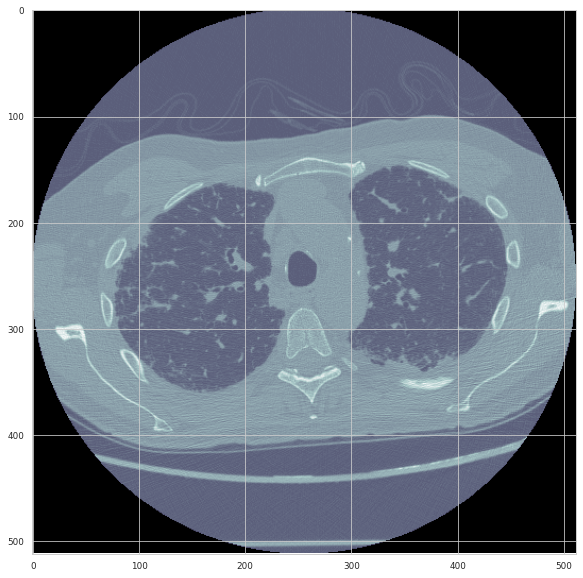

In [10]:
# We can plot the CT scan using matplotlib(the images pixel values are given in the variable dataset.pixel_array)
plt.figure(figsize=(10,10))
plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
plt.show()

We can see how a single slice looks. This is the CT scan itself. Multiple of these combine to give us a 3D image. I would highly recommend this notebook for getting a better ide of what the 3D scan looks like as there is a well put animation, https://www.kaggle.com/andradaolteanu/pulmonary-fibrosis-competition-eda-dicom-prep . As well as a good explanation for the various components. The notebook contains a lot of valuable information on Dicoms and this competition in general and is very easy to read. 

Next, we will understand the various parts of the image itself and the main concepts for preparing the image data.

1. Hounsfield's unit(HU): This is a crucial component of the image data. The Hounsfield scale is a scale used to measure the radiodensity of various materials. Essentially, they are measures used in CT scan for various materials. For example, air as a HU unit of -1000 bone has a relatively higher HU density with around 300+, metals etc have a very high HU values. With various substances with varying HU values. One interesting point to note is fibrotic tissue and regular tissue has varying levels of HU( with fibrotic tissue having higher values). The rescale type, scale etc. helps set the pixel values to the correct HU value. For example, a pixel with a value of 0, with a rescale intercept of -1000 and slope 10 gives the actual HU value for that pixel =0*10 +(-1000) = -1000( essentially the same as that of air). 
Therefore the values given in the table such as rescale type etc is useful for this convertion between pixel values and HU units.

2. Pixel slice location/ pixel thickness, pixel spacing: This is another important component while working with medical image data. For information regarding the volume of the lung etc, we need to be able to measure what the size and scale of the lung in terms of lengths. That is where slice location comes into play. Pixel slice location gives us the slice location(X,Y,Z) components of the image data. The z axis being most crucial. The Z axis tells us where along the Z axis is the image is taken( in cm). The pixel spacing gives us the conversion between the size of the image and the actual size.

3. Masking: The final component that is commonly used is the concept of masking. A lung mask is the segmented image of the lungs alone. Often, most of the information lies within the area of the lungs and the rest of the CT scan is noise. Do note there might many features that can be extracted from the rest of the CT scan( some of which Dr. Konya's discussion thread highlights). Therefore it might be a good idea, especially if we are using some kind of neural network to get a segmented image.

With that,we have come to an end to the concepts involved in medical imaging. Also, to be fair, a large number of the better scored notebooks etc. comes from mostly the tabular data. My highest scoring notebook (6.85) comes from mostly tabular data and just one variable extracted from images. However, I will also go through a few methods that I had tried as well.



## Incorporating uncertainty : 
One interesting feature about this competition is the requirement to provide a confidenc measure. The competition is evaluated on a modified version of the Laplace Log Likelihood. This involves two variables, one is the actual prediction and the other is our confidence. So essentially both play a crucial role in getting a good score.
The equations for the metric are as below :

σ clipped=max (σ,70),


Δ = min( |FVCtrue−FVCpredicted|, 1000),


metric=−2–√Δσclipped−ln(2–√σclipped)

now what the sigma clipped implies is there is a base amount of uncertainty to all of our predictions.( sigma is the uncertainty we give). We can see how the two variables play a role in the final metric and it becomes obvious our models too need to have an equally appropriate loss function. I would highly recommend https://www.kaggle.com/rohanrao/osic-understanding-laplace-log-likelihood notebook for a much deeper understanding of the metric. 

Having never had the opportunity to work with uncertainty I found this challenge interesting and predicting uncertainty seemed to complicate the problem further. Finally, I came to try 3 methods out of which one was a clear winner.

1. I first made predictions for the FVC  values, then using these as a variable, I made a neural network to predict the uncertainty values. This wasnt a great idea and did not work out too well.( It could be because if the neural network could predict uncertainty well, it could have also made better predictions on the FVC values).
2. Solving for the above equation. Solving the equation gives us a single uncertainty value that is optimal( I got a value of around 225, which I set as the uncertainty for all the readings). This was not a bad solution however, it improved the model considerably and gave us a pretty good rough estimate on the approximate average uncertainty. 
3. Finally, going through a few solutions, I found pinball loss. It is crucial to have an understanding of how this works and what happens. Pinball loss is a loss measured while using quantile regression. I would recommend going through this article to get a better understanding of what pinball loss is :

https://www.evergreeninnovations.co/blog-quantile-loss-function-for-machine-learning/#:~:text=As%20the%20name%20suggests%2C%20the,predict%2090%25%20of%20the%20times.&text=For%20a%20set%20of%20predictions%2C%20the%20loss%20will%20be%20its%20average  and also 

https://www.lokad.com/pinball-loss-function-definition#:~:text=The%20pinball%20loss%20function%20is,forecast%20is%20a%20subtle%20problem.&text=The%20pinball%20loss%20function%20returns,of%20a%20quantile%20forecasting%20model 
  it should be understood that quantile regression unlike regular linear regression, which is based on getting the mean, quantile regression uses the median or other quantiles for the prediction. Pinball loss, helps us work with quantiles by biasing our predictions.
  
 Here is the formula: 
 
 Let τ be the target quantile, y the real value and z the quantile forecast, then Lτ, the pinball loss function, can be written:

         Lτ(y,z) =(y−z)τ if y≥z

                  =(z−y)(1−τ) if z>y

Therefore, if we want to predict values the same as the forecast we set τ to be 0.5 and use the loss function. If we want our predictions to be on the lower side, we reduce the value of τ and similarly increase it if we want it to be on the higher side. This lets us build an interval and judge our confidence based on that.  For example, a prediction for the 0.25 quantile should be such that the true value is less than your predicton 25% of the time. The exact values of the target value is a bit of trial and error. 0.8 for the higher value and 0.2 for the lower end seems to give a fairly good score. 

Now for our loss function. The final loss function used a combination of this pinball loss, as well as our metric directly. Given below is the code:

In [11]:
#The score is the direct metric which is provided to us: 
def score(y_true, y_pred):
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    sigma = abs(y_pred[:,2] - y_pred[:,0])
    fvc_pred = y_pred[:,1]
    
    #sigma_clip = sigma + C1
    sigma_clip = tf.maximum(sigma, 70)
    delta = tf.abs(y_true[:, 0] - fvc_pred)
    delta = tf.minimum(delta, 1000)
    sq2 = tf.sqrt( tf.dtypes.cast(2, dtype=tf.float32) )
    metric = (delta / sigma_clip)*sq2 + tf.math.log(sigma_clip* sq2)
    return metric

#qloss is the pinball loss for the target quantiles 0.8,0.5, and 0.2 :
def qloss(y_true, y_pred):
    # Pinball loss for multiple quantiles
    qs = [0.8,0.5,0.2]
    q = tf.constant(np.array([qs]), dtype=tf.float32)
    e = y_true - y_pred
    v = tf.maximum(q*e, (q-1)*e)
    return kb.mean(v)
#mloss is the combination of both these loss functions which will be our final loss(_lambda is the ratio we weigh both these losses( also found using trial and erorr)):
def mloss(_lambda):
    def loss(y_true, y_pred):
        return _lambda * qloss(y_true, y_pred) + (1 - _lambda)*score(y_true, y_pred)
    return loss

With that we have come to the end of understanding loss functions and scoring, we have also written the code for the custom loss.

## Modelling methodologies:

For the tabular data, I have always used a basic neural network  with the custom loss function as above. One slight change from the loss above that gave me my best score is to use a separate neural network to make the prediction for the FVC values( instead of this custom metric, I simply used the Mean absolute error for  that. The uncertainty  was predicted using this custom loss.

My best model also used just 1 image related feature. And that is the average attenuation values. What that means is the average HU value of the lung. First, I got a segmented images of the lung using the library lungmask. Scaled the image using the pixel spacing values. Rescaled the image to HU values and took the average of the pixel values for the patients. This is rather simple data point but also quite useful. The reason being that fibrotic tissues have higher HU values. 

The other approach I tried was using an autoencoder. A well put discussion thread can be found here: https://www.kaggle.com/c/osic-pulmonary-fibrosis-progression/discussion/167025 . Here is my version of the autoencoder. It  did not produce great results but it was an interesting approach which possibly could be really useful in the future. https://www.kaggle.com/melvin97n/base-7?scriptVersionId=42355975 . To give a brief description of what an autoencoder does: An autoencoder is a type of artificial neural network used to learn efficient data codings in an unsupervised manner. The aim of an autoencoder is to learn a representation (encoding) for a set of data, typically for dimensionality reduction, by training the network to ignore signal “noise”. For example, my autoencoder reduced the dimension of 40 * 256 * 256(do note that 40 is there due to the fact that the image is a 3D one, and it was made into a 40 * 256 * 256 image by a lot of image processing) image to just 10 dimensions. This helps us fit it in with our tabular data and feed it for training.

I had tried one final method, by feeding the image along with some variables through the neural network to see if I could get any results, the training set did extremely well, however,  I could not translate the results( there is a high chance there was some amount of data leakage in that method). Here is a link : https://www.kaggle.com/melvin97n/base-8 (if anyone could point the exact problems of this particular model that would be really helpful as well).

Now with all the model methodologies explained, we can move to the actual modelling and processing the images.

## Processing the images: 

We will be first masking the images and then scaling them. For masking, I will be using the lungmask repository. (For kaggle, I have used a slightly modified version so as to make it work offline. Feel free to check the original at : https://github.com/JoHof/lungmask . It is extremely simple to use and produces extremely good results. A big drawback however, is the compute time. It takes few seconds for each image. What I had done to reduce compute time, is to take only one image from all the images for each patient hoping that it is a representative one.( I select the middle image to work with.

The first function is to mask the image, the second to scale it, and the final one is to select the middle image for each patient, scale and mask it.

In [15]:
# Masking function:
def masking(input):
  # used to read the image
  input_image = sitk.ReadImage(input)
  segmentation = mask.apply(input_image)
  dataset = pydicom.dcmread(input)
  segment_image=dataset.pixel_array
  segment_image=np.where(segmentation[0]==0,dataset.pixel_array.min(),segment_image)
  return(segment_image)

#scaling function:
def pixscale(input):
  dataset = pydicom.dcmread(input)
  scaled_image=dataset.pixel_array*dataset.RescaleSlope + dataset.RescaleIntercept
  return(scaled_image)
# selecting middle image and processing it:
how="test"
imagedir=f"{ROOT}/{how}"
def mid_image_test(patient,mask,scale, how="test"):
  directory=f"{ROOT}/{how}/{patient}/"
  images=glob.glob(directory+'*')
  images.sort(key = lambda x: int(x.split('/')[5].split('.dcm')[0]))
  dataset = pydicom.dcmread(images[1])
  slope=dataset.RescaleSlope
  intercept=dataset.RescaleIntercept
  image=images[int(len(images)/2)]
  if mask==True:
    image1=masking(image) 
  else:
    image1=pydicom.dcmread(image).pixel_array
  if scale==True:
    image1=(image1*slope) + intercept
    image1=np.where((image1>=1000)|(image1<=-1000),image1.min(),image1)
  return(image1)

Below, is an sample segmented image:

100%|██████████| 2/2 [00:00<00:00, 3198.10it/s]


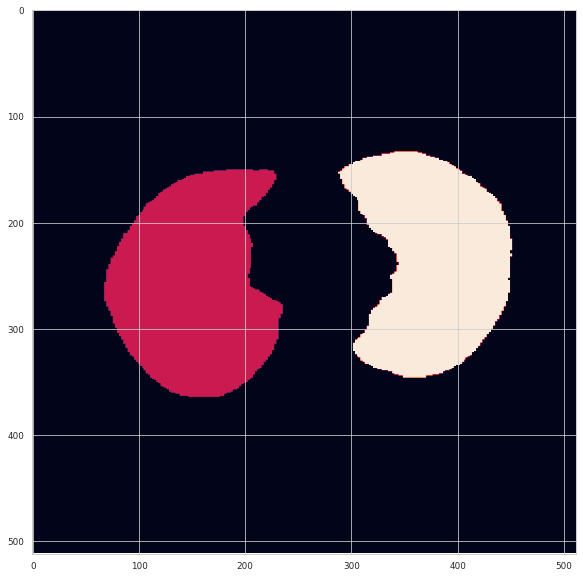

In [32]:
input_image = sitk.ReadImage('../input/osic-pulmonary-fibrosis-progression/train/ID00007637202177411956430/12.dcm')

segmentation = mask.apply(input_image)  
plt.figure(figsize=(10,10))
plt.imshow(segmentation[0])

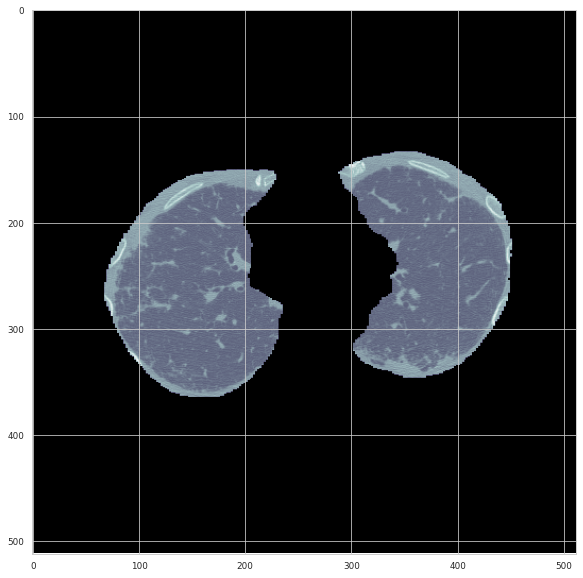

In [33]:
segmented_image=dataset.pixel_array
segmented_image=np.where(segmentation[0]==0,dataset.pixel_array.min(),segmented_image)
plt.figure(figsize=(10,10))
plt.imshow(segmented_image,cmap=plt.cm.bone)

To reduce compute time on Kaggle, I had stored the feature( I named atten( short for attenuation)) in a csv file for the training set. The feature is generated for the test set below:

In [16]:
#Storing the training set feature values in a dataframe called atten:

atten=pd.read_csv('../input/attent-1/atten (1).csv')

# Finding the attenuation values for every test patient and store in the variable avg_atten_Test:
patients=os.listdir(f"{ROOT}/{how}")
avg_atten_test=[]
for patient in patients:
    try: 
        mid=mid_image_test(patient,True,True)
        postives=mid>mid.min()
        mid[postives].mean()
        avg_atten_test.append(mid[postives].mean())
    except:
        avg_atten_test.append(np.nan)
        continue

100%|██████████| 11/11 [00:00<00:00, 5209.14it/s]


## Data Proprocessing:
Next, we will combine all these and get our final test and train sets.

In [20]:
# Here, we simply add the attenuation values onto the training set and define our target and explanatory variables :
final1=final.copy()
final1=final1.merge(atten,on='Patient')
X1=final1[['base_fvc','base_percent','Age','sex','smokingstatus','weeks_passed','avg_atten','base_week']].copy()
y1=final1.FVC.copy()

No we scale the data and use OneHotEncoder to encode the categorical variables.

In [21]:
# We use onehotencoder to encnode categorical variables(sex, smoking status):
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(X1[['sex','smokingstatus']])
encoded=pd.DataFrame(enc.transform(X1[['sex','smokingstatus']]).toarray())
X1=X1.join(encoded)
X1.drop(['smokingstatus','sex'],axis=1,inplace=True)
# We scale the entire dataset to the range 0-1 using MinMaxScaler:
scaler=preprocessing.MinMaxScaler().fit(X1)
X1=pd.DataFrame(scaler.transform(X1))
X1.head()

,0,1,2,3,4,5,6,7,8,9,10
0,0.26705,0.236393,0.769231,0.571429,0.35253,0.007246,0.0,1.0,0.0,1.0,0.0
1,0.26705,0.236393,0.769231,0.587302,0.35253,0.007246,0.0,1.0,0.0,1.0,0.0
2,0.26705,0.236393,0.769231,0.603175,0.35253,0.007246,0.0,1.0,0.0,1.0,0.0
3,0.26705,0.236393,0.769231,0.619048,0.35253,0.007246,0.0,1.0,0.0,1.0,0.0
4,0.26705,0.236393,0.769231,0.666667,0.35253,0.007246,0.0,1.0,0.0,1.0,0.0


Next, we format the test set also into the above format:

In [25]:
#adding the attenuation values to the dataframe for the test set:
atten_test=pd.DataFrame({'Patient':patients,'avg_atten':avg_atten_test})
atten_test['avg_atten']=atten_test['avg_atten'].fillna(atten["avg_atten"].mean())

# Scaling and converting the categorical values:
X_test=test.merge(atten_test,on='Patient')
X_test=X_test[['base_fvc','base_percent','Age','sex','smokingstatus','weeks_passed','avg_atten','base_week']].copy()
encoded=pd.DataFrame(enc.transform(X_test[['sex','smokingstatus']]).toarray())
X_test=X_test.join(encoded)
X_test.drop(['smokingstatus','sex'],axis=1,inplace=True)
X_test=pd.DataFrame(scaler.transform(X_test))
# Converting both the X1 and y1 variables to float:
X1=X1.astype(np.float32)
y1=y1.astype(np.float32)

### Modelling: 
We use a very simple neural network to make predictions. We have 3 outputs, one for the actual prediction, and one for lower end confidence interval and the other higher end. The difference between the two give us the uncertainty/ confidence values:

In [22]:

# Forming our Neural network :
inputs= keras.Input(shape=[11])
dense = layers.Dense(100, activation="relu")
x = dense(inputs)
x = layers.Dense(100, activation="relu")(x)
#x = layers.Dense(100, activation="relu")(x)
output1 = layers.Dense(3,activation='linear')(x)
model = keras.Model(inputs=inputs, outputs=output1)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 11)]              0         
_________________________________________________________________
dense (Dense)                (None, 100)               1200      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 303       
Total params: 11,603
Trainable params: 11,603
Non-trainable params: 0
_________________________________________________________________


The loss function is the mloss function defined above.  We will be using the "adam"  optimizer and a batch size of 512.

In [23]:
model.compile(loss=mloss(0.8),optimizer='adam',metrics=score)
model.fit(X1, y1,batch_size=512,epochs=130)

Epoch 1/130
24/24 [==============================] - 0s 3ms/step - loss: 1088.0168 - score: 24.7877
Epoch 2/130
24/24 [==============================] - 0s 2ms/step - loss: 1086.6483 - score: 24.7873
Epoch 3/130
24/24 [==============================] - 0s 2ms/step - loss: 1082.0677 - score: 24.7860
Epoch 4/130
24/24 [==============================] - 0s 2ms/step - loss: 1069.9264 - score: 24.7816
Epoch 5/130
24/24 [==============================] - 0s 2ms/step - loss: 1044.3590 - score: 24.7707
Epoch 6/130
24/24 [==============================] - 0s 3ms/step - loss: 998.5488 - score: 24.7514
Epoch 7/130
24/24 [==============================] - 0s 3ms/step - loss: 925.5917 - score: 24.6736
Epoch 8/130
24/24 [==============================] - 0s 2ms/step - loss: 818.6904 - score: 24.3258
Epoch 9/130
24/24 [==============================] - 0s 2ms/step - loss: 671.5217 - score: 22.7335
Epoch 10/130
24/24 [==============================] - 0s 2ms/step - loss: 486.7707 - score: 14.2476
Epoc

24/24 [==============================] - 0s 3ms/step - loss: 65.9990 - score: 7.0150
Epoch 85/130
24/24 [==============================] - 0s 3ms/step - loss: 65.7539 - score: 7.0087
Epoch 86/130
24/24 [==============================] - 0s 2ms/step - loss: 65.4513 - score: 7.0053
Epoch 87/130
24/24 [==============================] - 0s 3ms/step - loss: 65.1507 - score: 6.9990
Epoch 88/130
24/24 [==============================] - 0s 3ms/step - loss: 64.8965 - score: 6.9931
Epoch 89/130
24/24 [==============================] - 0s 2ms/step - loss: 64.6453 - score: 6.9876
Epoch 90/130
24/24 [==============================] - 0s 2ms/step - loss: 64.3955 - score: 6.9866
Epoch 91/130
24/24 [==============================] - 0s 2ms/step - loss: 64.1505 - score: 6.9792
Epoch 92/130
24/24 [==============================] - 0s 2ms/step - loss: 63.9276 - score: 6.9746
Epoch 93/130
24/24 [==============================] - 0s 2ms/step - loss: 63.6758 - score: 6.9727
Epoch 94/130
24/24 [=============

We have trained our model and now we have to make the predictions for our test set:

In [26]:
preds_high=model.predict(X_test)[:,0]
preds_low=model.predict(X_test)[:,2]
preds=model.predict(X_test)[:,1]

Let us combine it into a dataframe and see the results and predictions:

In [28]:
preds_set=pd.DataFrame({'preds_high':preds_high})
preds_set['preds']=preds
preds_set['preds_low']=preds_low
preds_set['sigma_pred']=abs(preds_set['preds_high']-preds_set['preds_low'])
preds_set.reset_index(inplace=True,drop=True)

preds_set

,preds_high,preds,preds_low,sigma_pred
0,3099.460205,2937.026855,2769.965576,329.494629
1,3094.764404,2932.550781,2765.731689,329.032715
2,3090.068115,2928.074219,2761.498047,328.570068
3,3085.372314,2923.597900,2757.264404,328.107910
4,3080.676514,2919.122070,2753.030762,327.645752
...,...,...,...,...
725,2462.092041,2331.324707,2197.236816,264.855225
726,2458.554443,2327.960449,2194.056641,264.497803
727,2455.016846,2324.595703,2190.875488,264.141357
728,2451.479736,2321.230957,2187.694824,263.784912


## Submission and scoring: 
There are a few points to note while submitting. The submission should be in the exact format as the sample_submission, and should have the name submission.csv. Another point to note, the test csv provided is not the test data that is scored against. The csv is swapped while scoring. 

In [31]:
# Forming the submission csv:
submission=pd.DataFrame({'Patient_Week':test['Patient_Week'],'FVC': preds_set['preds'],'Confidence':preds_set['sigma_pred']})
submission['FVC']=submission['FVC'].apply(lambda x: round(x, 4))/1
submission['Confidence']=submission['Confidence'].apply(lambda x: round(x, 4))
submission.to_csv('submission.csv',index=False)             
submission.head()

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,2937.0269,329.4946
1,ID00419637202311204720264_-11,2932.5508,329.0327
2,ID00419637202311204720264_-10,2928.0742,328.5701
3,ID00419637202311204720264_-9,2923.5979,328.1079
4,ID00419637202311204720264_-8,2919.1221,327.6458


With that we have come to an end to the modelling, submission and scoring. Finally we can see what can be done further to improve on the scores.

## Future work and conclusion:
There are a lot of things that can be done further to improve our model.
1. The biggest one is to bring in more hand picked features from the image data. A very good explanation is made in the 2 of Dr. Konyas discussion threads( he is going to shortly provide a 3rd discussion thread).
2. Work on a better autoencoder which can get valuable information from the image data. 
3. Further tune the models and the loss functions to make it optimum.

With that we have come to the conclusion of this notebook. Feel free to ask any doubts, suggestions and constructive criticism is valued. All credits due are given to those who I have put up a link to in the notebook.